<a href="https://colab.research.google.com/github/Alina-Zakirova/equipment-failure-prediction/blob/main/%D0%A4%D0%98%D0%9D%D0%90%D0%9B_%D0%9A%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4%D0%B0_3_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D1%83%D0%BC_%D0%9A%D0%B5%D0%B9%D1%81_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# **Кейс №7_Бинарная классификация отказов оборудования**

---


### **Описание задания:**
Нужно предсказать, произойдёт ли отказ оборудования на основе его технических характеристик, условий эксплуатации и истории работы

### **Ожидаемый результат:**
Обученная модель бинарной классификации, определяющая вероятность отказа оборудования

### **Основной функционал:**
- Импорт и анализ исторических данных;
- Предобработка и очистка данных;
- Обучение модели (SVM, деревья решений);
- Оценка метрик Precision, Recall, ROC-AUC.



# **0. Импорт необходимых библиотек**

In [ ]:
!pip install kaggle
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-25' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    s

In [ ]:
#Подготовка к работе с Kaggle API
from google.colab import files
import os

#Создадим загрузчик для файла kaggle.json через интерфейс Colab
files.upload()

#Создадим папку, в которую добавим наш файл и дадим права доступа
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **1. Знакомство с данными**

In [ ]:
#Ссылка на источник данных
url = "https://www.kaggle.com/competitions/playground-series-s3e17/overview"
source_name = "PLAYGROUND PREDICTION COMPETITION · Binary Classification of Machine Failures"

html_link = f'''
<div style="margin: 10px; padding: 10px; background: #f0f8ff; border-radius: 5px;">
    <span style="font-size: 14px; color: #555;">🔗 Источник данных на Kaggle:</span>
    <a href="{url}" target="_blank" style="color: #1a73e8; text-decoration: none; font-weight: bold;">{source_name}</a>
</div>
'''

display(HTML(html_link))

In [ ]:
#Загрузим данные напрямую из Kaggle, используя API нужных нам датасетов
!kaggle competitions download -c playground-series-s3e17

#Распаковываем архив c нашими данными
with zipfile.ZipFile('playground-series-s3e17.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

#Загружаем данные в переменную data_test и data_train
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')

playground-series-s3e17.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Проверка скачались ли наши файлы (архив) через API
!ls

playground-series-s3e17.zip  sample_data	    test.csv
__pycache__		     sample_submission.csv  train.csv


## **Функция для вывода основной информации по датасету**
Будет использована и для тестовой, и для обучающей выборки


*P.S. Выведена отдельно, чтобы каждый член команды мог всегда ее найти*

In [ ]:
def analyze_uniqueness(df):
    analysis = pd.DataFrame({
        'Тип данных': df.dtypes,
        'Всего значений': len(df),
        'Пропущенные значения': df.isnull().sum(),
        'Уникальные значения': df.nunique(),
        'Процент уникальности': (df.nunique() / len(df)) * 100
    })
    return analysis.sort_values('Уникальные значения', ascending=False)

## **1.1. Обучающая выборка**

In [ ]:
data_train_raw = data_train.copy()
data_train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [ ]:
train_analysis = analyze_uniqueness(data_train)
display(train_analysis.style.background_gradient(cmap='coolwarm', subset=['Процент уникальности']))

,Тип данных,Всего значений,Пропущенные значения,Уникальные значения,Процент уникальности
id,int64,136429,0,136429,100.000000
Product ID,object,136429,0,9976,7.312228
Rotational speed [rpm],int64,136429,0,952,0.697799
Torque [Nm],float64,136429,0,611,0.447852
Tool wear [min],int64,136429,0,246,0.180314
Air temperature [K],float64,136429,0,95,0.069633
Process temperature [K],float64,136429,0,81,0.059372
Type,object,136429,0,3,0.002199
Machine failure,int64,136429,0,2,0.001466
TWF,int64,136429,0,2,0.001466


In [ ]:
#Посмотрим внимательнее на уникальные значения для `Type`
data_train['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

In [ ]:
train_duplicates = data_train.duplicated().any()

if train_duplicates:
    print("В датасете есть дубликаты!")
    print(f"Общее количество дубликатов: {data_train.duplicated().sum()}")
else:
    print("Дубликатов не найдено")

Дубликатов не найдено


# **1.2. Тестовая выборка**

In [ ]:
data_test_raw = data_test.copy()
data_test.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [ ]:
test_analysis = analyze_uniqueness(data_test)
display(test_analysis.style.background_gradient(cmap='coolwarm', subset=['Процент уникальности']))

,Тип данных,Всего значений,Пропущенные значения,Уникальные значения,Процент уникальности
id,int64,90954,0,90954,100.000000
Product ID,object,90954,0,9909,10.894518
Rotational speed [rpm],int64,90954,0,946,1.040086
Torque [Nm],float64,90954,0,595,0.654177
Tool wear [min],int64,90954,0,246,0.270466
Air temperature [K],float64,90954,0,92,0.101150
Process temperature [K],float64,90954,0,84,0.092354
Type,object,90954,0,3,0.003298
TWF,int64,90954,0,2,0.002199
HDF,int64,90954,0,2,0.002199


In [ ]:
test_duplicates = data_test.duplicated().any()

if test_duplicates:
    print("В датасете есть дубликаты!")
    print(f"Общее количество дубликатов: {data_test.duplicated().sum()}")
else:
    print("Дубликатов не найдено")

Дубликатов не найдено


### **Данные**

Обучающая и тестовая выборки заданы заранее:

- **train.csv - обучающая выборка**
  - Содержит 136429 значений;
  - Не содержит пропусков;
  - Не содержит дубликатов.

- **test.csv - тестовая выборка**
  - Содержит 90954 значения;
  - Не содержит пропусков;
  - Не содержит дубликатов.
---

### **Описание столбцов:**
- **id** - идентификатор записи в датасете;

- **Product ID** - уникальный номер экземпляра оборудования/машины. Состоит из буквы (L/M/H, которая обозначает качество машины) и серийного номера;

***На подумать:*** так как не все айдишники продуктов уникальные, делаем выводы, что наблюдаем за 1 и тем же набором 9976 машин. Скорее всего у нас дана информация за n-ный временной период, и можно поискать зависимости, с какого наблюдения машины начинают ломаться/есть ли случаи, когда 1 тип ошибки ведет за собой какой-то 2 и т.д. Именно по этой причине я не стала удалять просто айдишники записей, возможно, их можно будет поранжировать.

- **Rotational speed [rpm]** - частота вращения машины (оборотов в минуту);

- **Torque [Nm]** - крутящий момент (Ньютон-метров);

- **Tool wear [min]** - износ оборудования (минут); сколько минут работало оборудование). Чем выше качество оборудования (Type), тем дольше оно может работать в рамках 1 запуска;

- **Air temperature [K]** - температура воздуха в кельвинах;

- **Process temperature [K]**- температура процесса в кельвинах.
Формула расчета: температура воздуха + 10K;

- **Type** - обозначает качество конкретного экземпляра оборудования и влияет на его износ:
  - H - высокое (+5 минут),
  - M - среднее (+3 минуты),
  - L - низкое (+2 минуты);

- **Machine failure** - отображает факт ошибки в работе оборудования: 0 - ошибки нет, 1 - ошибка есть.

**Возможные ошибки/неисправности/причины поломки:**
- **TWF** - tool wear failure, неисправность из-за износа оборудования
  - Оборудование заменяется или выходит из строя при износе 200-240 минут;

- **HDF** - heat dissipation failure, неисправность из-за нарушения теплоотдачи. Возникает, если:
  - Разница между температурой процесса и воздуха < 8.6K,
  - Скорость вращения < 1380 об/мин;

- **PWF** - power failure, неисправность из-за недостатка мощности (крутящего момента)
  - Отказ, если мощность (крутящий момент × скорость) выходит за пределы 3500-9000 Вт;

- **OSF** - неисправность из-за перенапряжения. Отказ при превышении порога:
  - L: (износ × крутящий момент) > 11000 мин×Нм,
  - M: > 12000 мин×Нм,
  - H: > 13000 мин×Нм;

- **RNF**	- random failures, случайная неисправность. Вероятность отказа 0.1% независимо от параметров.

**ВАЖНО:** Если хотя бы одна из вышеперечисленных ошибок имеет значение true, работа оборудования завершается сбоем, метке "Machine failure" присваивается значение 1

***Подробнее о данных можно прочитать [ЗДЕСЬ](https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020)***


---

### **Цель:**
Предсказать **вероятность** выхода оборудования из строя (ошибка/отказ оборудования)

=> **Целевой признак:** `Machine Failure`

# **1.3 Распределение ошибок для каждого типа оборудования**

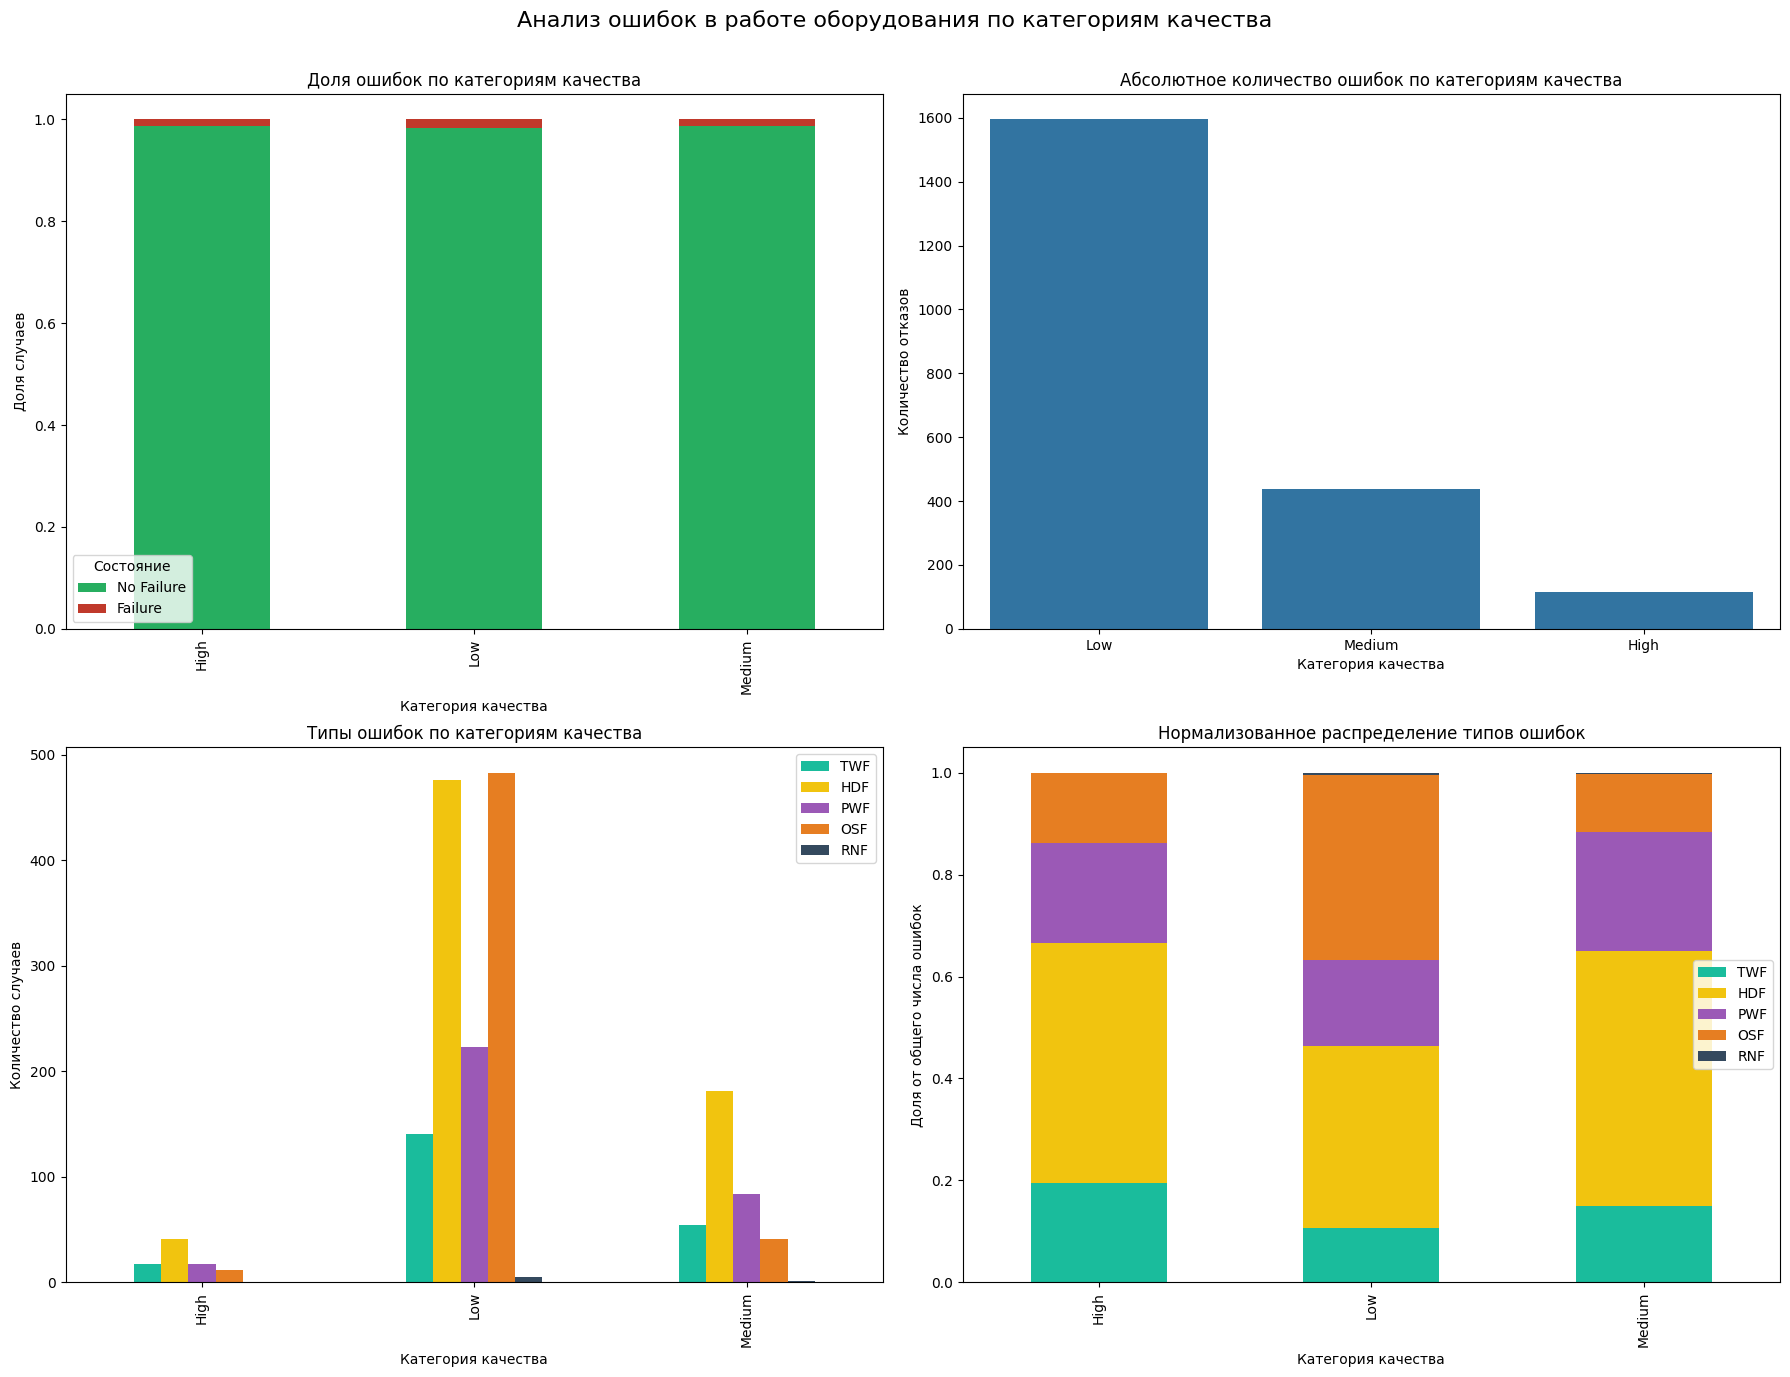


1. Доля ошибок по категориям качества:


Machine failure,No Failure,Failure
quality,,
High,0.987000,0.013000
Low,0.983273,0.016727
Medium,0.986408,0.013592



2. Абсолютное количество ошибок:


,Количество ошибок
quality,
Low,1595
Medium,437
High,116



3. Распределение типов ошибок:


,TWF,HDF,PWF,OSF,RNF
quality,,,,,
High,17,41,17,12,0
Low,141,476,223,483,5
Medium,54,181,84,41,1



4. Нормализованное распределение типов ошибок:


,TWF,HDF,PWF,OSF,RNF
quality,,,,,
High,0.195402,0.471264,0.195402,0.137931,0.000000
Low,0.106175,0.358434,0.167922,0.363705,0.003765
Medium,0.149584,0.501385,0.232687,0.113573,0.002770


In [ ]:
# 1. Определяем категорию качества на основании столбца "Type" нашего датасета
data_train['quality'] = data_train['Type'].map({'L': 'Low', 'M': 'Medium', 'H': 'High'})

# 2. Посмотрим на распределение оошибок по категориям качества
failure_distribution = pd.crosstab(data_train['quality'], data_train['Machine failure'], normalize='index').rename(columns={0: 'No Failure', 1: 'Failure'})

# 3. Посмотрим на абсолютное количество ошибок по каждой категории качества
absolute_failures = data_train[data_train['Machine failure'] == 1]['quality'].value_counts()

# 4. Распределение типов ошибок по категориям качества
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_types_dist = data_train[data_train['Machine failure'] == 1].groupby('quality')[failure_modes].sum()

# ВИЗУАЛИЗАЦИЯ
# Чтобы "не плодить" графики, выведем 4 графика в рамках 1 фигуры
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Анализ ошибок в работе оборудования по категориям качества', fontsize=16)

# График 1: Доля ошибок по категориям качества
failure_distribution.plot(kind='bar', stacked=True, ax=axes[0,0], color=['#27ae60', '#c0392b'])
axes[0,0].set_title('Доля ошибок по категориям качества')
axes[0,0].set_ylabel('Доля случаев')
axes[0,0].set_xlabel('Категория качества')
axes[0,0].legend(title='Состояние')

# График 2: Абсолютное количество ошибок
sns.barplot(x=absolute_failures.index, y=absolute_failures.values, ax=axes[0,1])
axes[0,1].set_title('Абсолютное количество ошибок по категориям качества')
axes[0,1].set_ylabel('Количество отказов')
axes[0,1].set_xlabel('Категория качества')

# График 3: Типы ошибок по категориям качества
failure_types_dist.plot(kind='bar', ax=axes[1,0], color=['#1abc9c', '#f1c40f', '#9b59b6', '#e67e22', '#34495e'])
axes[1,0].set_title('Типы ошибок по категориям качества')
axes[1,0].set_ylabel('Количество случаев')
axes[1,0].set_xlabel('Категория качества')

# График 4: Нормализованное распределение типов ошибок
#какой % каждый тип ошибки занимает в общем количестве ошибок для конкретной категории оборудования.
(failure_types_dist.div(failure_types_dist.sum(axis=1), axis=0)).plot(kind='bar',
                                                                    stacked=True,
                                                                    ax=axes[1,1],
                                                                    color=['#1abc9c', '#f1c40f', '#9b59b6', '#e67e22', '#34495e'])
axes[1,1].set_title('Нормализованное распределение типов ошибок')
axes[1,1].set_ylabel('Доля от общего числа ошибок')
axes[1,1].set_xlabel('Категория качества')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Для любителей аналитики в табличном виде <3
# Вывод таблиц с данными
print("\n1. Доля ошибок по категориям качества:")
display(failure_distribution.style.background_gradient(cmap='Set2', subset=['Failure']))

print("\n2. Абсолютное количество ошибок:")
display(absolute_failures.to_frame('Количество ошибок').style.background_gradient(cmap='Set2'))

print("\n3. Распределение типов ошибок:")
display(failure_types_dist.style.background_gradient(cmap='Set2'))

print("\n4. Нормализованное распределение типов ошибок:")
display(failure_types_dist.div(failure_types_dist.sum(axis=1), axis=0).style.background_gradient(cmap='Set2'))

## **Промежуточный вывод об ошибках для каждого типа оборудования**

### **Общая частота ошибок:**
Несмотря на различия в распространенных ошибках для оборудования разного качества, общая доля ошибок для всех категорий находится в диапазоне 1.3-1.7%, что указывает на:
- Высокую надежность оборудования независимо от его категории (L/M/H);
- Эффективность системы предупреждения ошибок;
- Low-оборудование имеет незначительно повышенную частоту ошибок (1.67% vs 1.3-1.36% для High/Medium), что обуславливает его "популярность" на фоне оборудования среднего и высокого качества (50% от общего количества).

**Случайные ошибки (RNF):**
- Не встречаются в высококачественном оборудовании (0%),
- Имеют минимальные значения для Low (0.38%) и Medium (0.28%), что в целом соответствует заявленной вероятности в 0.1%.

### **Абсолютные показатели:**
**Преобладание ошибок в Low-категории** (1595 случаев) объясняется:
- Большим количеством такого оборудования в эксплуатации (50% от общего числа)
- Более высокой склонностью к перегрузкам (OSF - 483 случая)
- Проблемами с теплоотведением (HDF - 30%)

**Medium-оборудование** (437 случаев):

Для Medium-качества лидирует HDF (50.1%), но с заметной долей PWF (Power Failure - 23.3%).

**High-оборудование** (116 случаев):

Для оборудования High-качества основной причиной отказов является HDF (Heat Dissipation Failure - 47.1%), что почти в 2 раза чаще, чем другие типы. Это может указывать на проблемы с теплоотведением при интенсивной эксплуатации дорогостоящего оборудования.


---

## **Следующий шаг для проведения анализа:**

Выясним, какие значения являются критическими для возникновения ошибок.
Так, например, для высококачественного оборудования основная проблема - теплоотведение. Выявим, какая температура является причиной поломки.



## **Функция для определения критических значений отдельных параметров, которые приводят к возникновению ошибок**

**Ее суть** - определение критических порогов (1.5*IQR для выбросов) в параметрах, которые являются причиной возникновения ошибки
Так, например, для OSF критическими являются: крутящий момент и износ инструмента:
1. Выберем кейсы, которые соответстуют следующей логике:
  - Тип оборудования = L,
  - Ошибка = OSF,
  - Наличие ошибки = да
2. Найдем те значения параметров, достижение которых ВСЕГДА приводит к ошибке

*P.S. Выведена отдельно, чтобы каждый член команды мог всегда ее найти*

In [ ]:
# Cоздадим функцию analyze_critical_values(df)

def analyze_critical_values(df):
    # Создаем словарь для хранения критических значений для самых популярных ошибок
    critical_values = {
        'High': {'Failure': 'HDF', 'Metrics': ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]']},
        'Medium': {'Failure': 'HDF', 'Metrics': ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]']},
        'Low': {'Failure': 'OSF', 'Metrics': ['Torque [Nm]', 'Tool wear [min]']}
    }

    df['Quality'] = df['Type'].map({'L': 'Low', 'M': 'Medium', 'H': 'High'})

    results = {}

    for quality in ['High', 'Medium', 'Low']:
        failure_type = critical_values[quality]['Failure']
        metrics = critical_values[quality]['Metrics']

        # Фильтруем данные для текущего типа оборудования с нужным нам типом ошибки
        failure_data = df[(df['Quality'] == quality) & (df[failure_type] == 1)]

        # Анализируем критические параметры
        analysis = {}
        for metric in metrics:
            stats = failure_data[metric].describe(percentiles=[0.05, 0.25, 0.75, 0.95])
            analysis[metric] = {
                'mean': stats['mean'],
                'median': stats['50%'],
                '5th_percentile': stats['5%'],
                '95th_percentile': stats['95%'],
                'critical_threshold': stats['75%'] + 1.5*(stats['75%'] - stats['25%'])  # Правило 1.5*IQR для выбросов
            }

        results[quality] = {
            'failure_type': failure_type,
            'critical_params': analysis
        }

        # Визуализация: ящики с усами для наглядного определения критических значений
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Критические значения параметров для {quality}-качества (Ошибка {failure_type})', y=1.02)

        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, len(metrics), i)
            sns.boxplot(x=failure_data[metric])
            plt.axvline(analysis[metric]['critical_threshold'], color='r', linestyle='--')
            plt.title(metric)
            plt.xlabel('Значение')

        plt.tight_layout()
        plt.show()

    return results

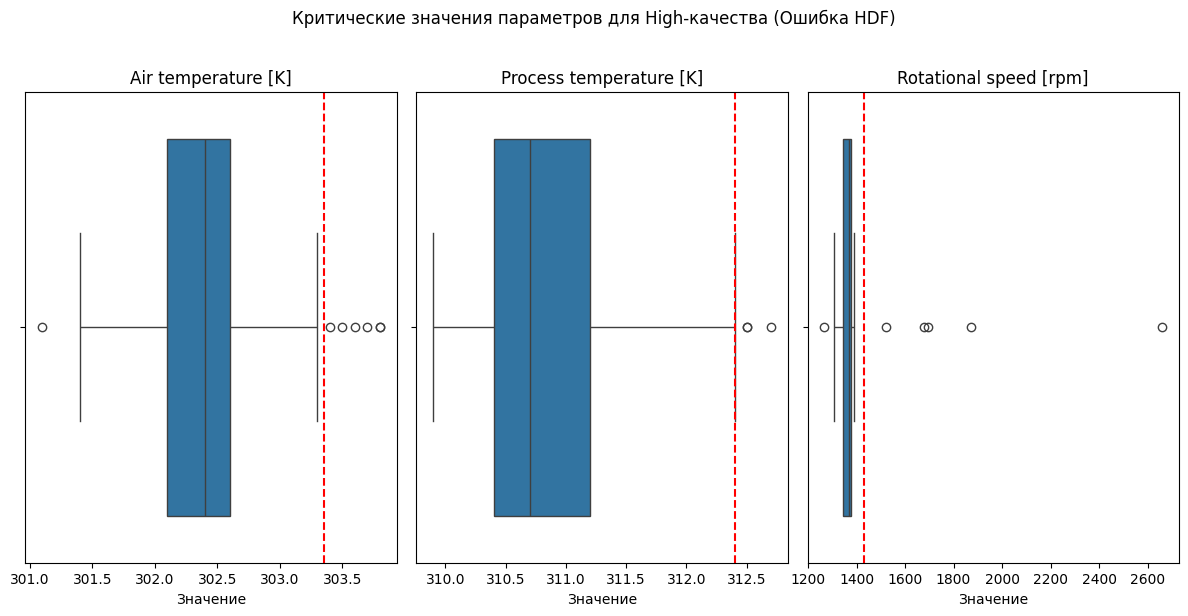

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-11' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "<ipython-input-5-92994bf062bf>", line 96, in <cell line: 0>
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.ru

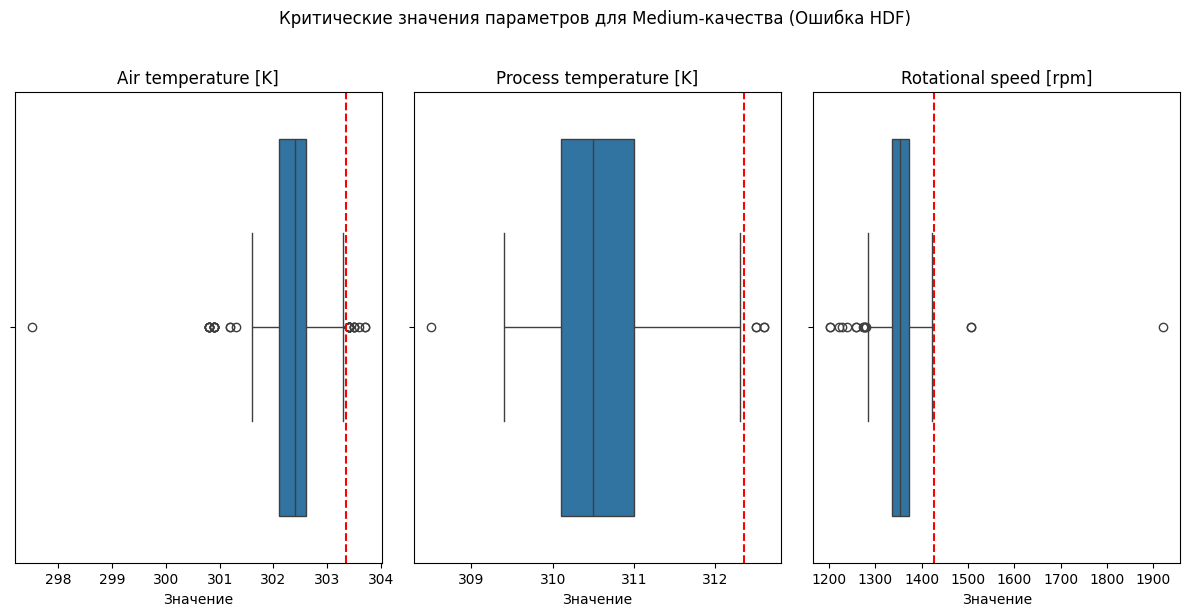

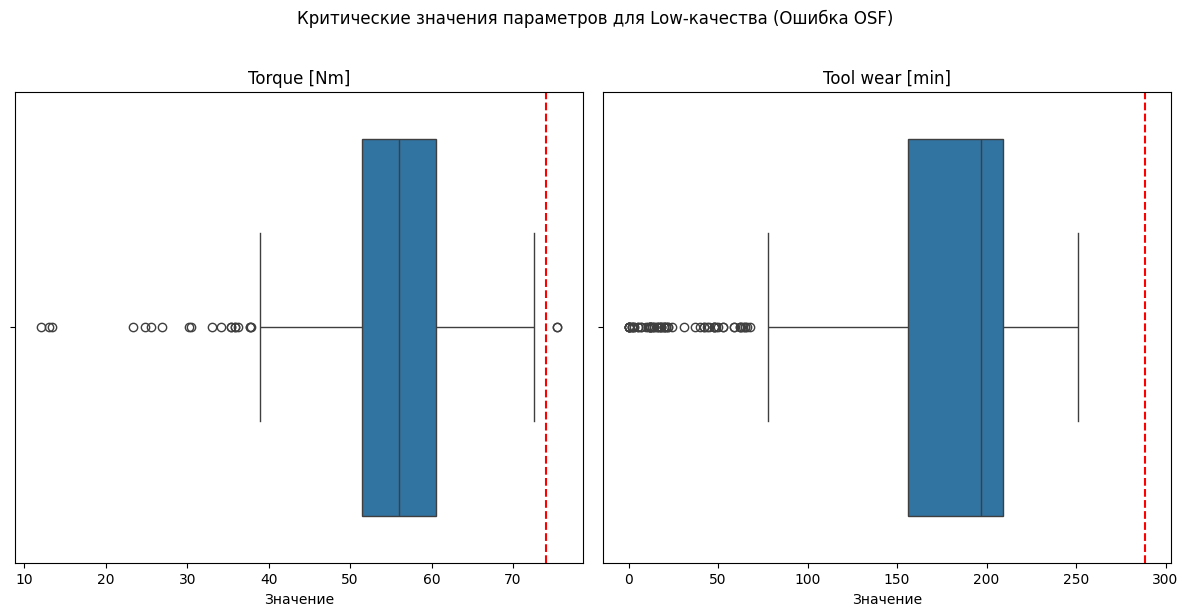


=== High-качество ===
Основная ошибка для оборудования High-качества: HDF


,mean,median,5th_percentile,95th_percentile,critical_threshold
Air temperature [K],302.478049,302.400000,301.700000,303.700000,303.350000
Process temperature [K],310.887805,310.700000,310.100000,312.500000,312.400000
Rotational speed [rpm],1420.146341,1368.000000,1313.000000,1694.000000,1430.000000



=== Medium-качество ===
Основная ошибка для оборудования Medium-качества: HDF


,mean,median,5th_percentile,95th_percentile,critical_threshold
Air temperature [K],302.326882,302.400000,300.900000,303.400000,303.350000
Process temperature [K],310.611828,310.500000,309.400000,311.900000,312.350000
Rotational speed [rpm],1350.682796,1353.000000,1276.500000,1393.500000,1427.500000



=== Low-качество ===
Основная ошибка для оборудования Low-качества: OSF


,mean,median,5th_percentile,95th_percentile,critical_threshold
Torque [Nm],55.106776,56.000000,40.960000,66.340000,74.000000
Tool wear [min],169.036961,197.000000,14.000000,228.000000,288.500000


In [ ]:
# Воспользуемся написанной функцией
critical_analysis = analyze_critical_values(data_train)

# Для любителей аналитики в табличном виде <3
# Вывод таблиц с данными
for quality, data in critical_analysis.items():
    print(f"\n=== {quality}-качество ===")
    print(f"Основная ошибка для оборудования {quality}-качества: {data['failure_type']}")

    df = pd.DataFrame(data['critical_params']).T
    display(df.style.background_gradient(cmap='Set2', subset=['critical_threshold']))

## **Итоговый вывод по ошибкам для каждого типа оборудования**

### **1. Оборудование High Quality (высокий класс)**

**Основная проблема:** Отказы из-за перегрева (HDF)

**Критические параметры:**
- Температура воздуха:
  - Превышение 303.35K (критический порог) значительно увеличивает риск отказа.
  - 95% отказов происходят при температуре до 303.7K, но системные сбои начинаются уже после 303.35K.

- Температура процесса:
  - Критическое значение — 312.4K.
  - Средняя температура при отказах — 310.89K, но пиковые значения (>312.5K) особенно опасны.

- Скорость вращения:
  - Превышение 1430 rpm ведет к повышенному риску.
  - В 95% случаев отказы происходят при скорости до 1694 rpm, но устойчивая работа нарушается уже после 1430 rpm.

### **2. Оборудование Medium Quality (средний класс)**

**Основная проблема:** Отказы из-за перегрева (HDF)

**Критические параметры:**
- Температура воздуха:
  - Риск отказа резко возрастает после 303.35K.
  = 95% отказов происходят при до 303.4K, но критический порог близок к этому значению.
- Температура процесса:
  - Критический порог — 312.35K.
  - Среднее значение при отказах — 310.61K, но опасны скачки выше 311.9K.
- Скорость вращения:
  - Превышение 1427.5 rpm — зона риска.
  - В 95% случаев отказы фиксируются при до 1393.5 rpm, но критические значения начинаются раньше.

### **3. Оборудование Low Quality (низкий класс)**

**Основная проблема:** Отказы из-за перегрузок (OSF)

**Критические параметры:**
- Крутящий момент:
  - Критическое значение — 74 Nm, но 95% отказов происходят уже при 66.34 Nm.
  - Среднее значение момента при отказах — 55.1 Nm, что указывает на повышенный износ при длительных нагрузках.
- Износ инструмента:
  - Критический порог — 288.5 мин, но 95% отказов случаются до 228 мин.
  - Медианное значение при отказах — 197 мин, что говорит о необходимости замены инструмента до 200 мин.

## **Кодирование категориальных признаков**

**Категориальный признак в нашем датасете — это Type (L, M, H).**

 Для него лучше применить One-Hot Encoding, так как это номинальная переменная без порядка. One-Hot Encoding создаст три новых бинарных признака (Type_L, Type_M, Type_H), что поможет моделям лучше интерпретировать данные.

In [ ]:
# One-Hot Encoding для признака 'Type'
data_train = pd.get_dummies(data_train, columns=['Type'], prefix='Type')
data_test = pd.get_dummies(data_test, columns=['Type'], prefix='Type')

# Проверка результата
print(data_train.head())

   id Product ID  Air temperature [K]  Process temperature [K]  \
0   0     L50096                300.6                    309.6   
1   1     M20343                302.6                    312.1   
2   2     L49454                299.3                    308.5   
3   3     L53355                301.0                    310.9   
4   4     M24050                298.0                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   
3                    1524         44.3              197                0    0   
4                    1641         35.4               34                0    0   

   HDF  PWF  OSF  RNF quality Quality  Type_H  Type_L  Type_M  
0    0    0    0    0     Low     Low   False    Tru

## **Нормализация числовых признаков**

Числовые признаки (например, Air temperature [K], Rotational speed [rpm] и др.) имеют разные масштабы. Для их нормализации выберем **StandardScaler**, который преобразует данные так, чтобы их распределение имело среднее 0 и стандартное отклонение 1. Это особенно полезно для алгоритмов, чувствительных к масштабу (например, SVM).

In [ ]:
from sklearn.preprocessing import StandardScaler

# Выбираем числовые признаки для нормализации
numeric_features = ['Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Инициализация StandardScaler
scaler = StandardScaler()

# Применяем нормализацию к обучающей и тестовой выборкам
data_train[numeric_features] = scaler.fit_transform(data_train[numeric_features])
data_test[numeric_features] = scaler.transform(data_test[numeric_features])

# Проверка результата
print(data_train[numeric_features].head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.395880                -0.246230                0.545416   
1             1.469856                 1.558605                1.720308   
2            -0.302204                -1.040358                2.051873   
3             0.610675                 0.692284                0.026445   
4            -1.000288                -0.679391                0.869773   

   Torque [Nm]  Tool wear [min]  
0    -0.499711         0.556417  
1    -1.323028         1.494433  
2    -1.628831        -1.241447  
3     0.464745         1.447532  
4    -0.582043        -1.100744  


## **Выводы: Основные особенности данных, важные для модели**
**1. Распределение ошибок по типам оборудования:**

- Low-качество (L): Наиболее частые отказы (1.67%), основные причины — перегрузки (OSF, 36.4%) и проблемы с теплоотведением (HDF, 35.8%).

- Medium-качество (M): Отказы реже (1.36%), доминирует HDF (50.1%).

- High-качество (H): Наименьшее количество отказов (1.3%), основная проблема — HDF (47.1%).

**2. Критические параметры для отказов:**

- High/Middle (HDF):

  - Температура воздуха: >303.35K (High), >303.35K (Medium).

  - Температура процесса: >312.4K (High), >312.35K (Medium).

  - Скорость вращения: >1430 rpm (High), >1427.5 rpm (Medium).

- Low (OSF):

  - Крутящий момент: >74 Nm (критический порог), но 95% отказов уже при >66.34 Nm.

  - Износ инструмента: >288.5 мин (критический порог), но 95% отказов до 228 мин.

**3. Дисбаланс классов:**

Целевой признак Machine failure сильно несбалансирован: только ~1.5% случаев — отказы. Необходимо применить методы балансировки (например, SMOTE) или использовать взвешенные метрики.

# **2. Инжиниринг признаков**



**1. Генерация новых признаков:**

In [ ]:
def create_features(df):
    """
    Создает новые признаки на основе исходных данных.

    Параметры:
    df - DataFrame с исходными данными

    Возвращает:
    df - DataFrame с добавленными признаками
    new_cols - список названий новых столбцов
    """

    # 1. Отношение температур процесса к воздушной
    # Логика: Это соотношение показывает эффективность теплоотведения.
    # Значения близкие к 1 указывают на плохой теплообмен, что может приводить к перегреву.
    df["Temperature ratio"] = df['Process temperature [K]'] / df['Air temperature [K]']

    # 2. Произведение крутящего момента и скорости вращения
    # Логика: Показывает механическую мощность/нагрузку на оборудование.
    # Высокие значения могут указывать на перегрузку системы.
    df['Torque * Rotational speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    # 3. Произведение крутящего момента и износа инструмента
    # Логика: Комбинированный показатель износа при нагрузке.
    # Чем выше значение, тем больше риск поломки из-за изношенного инструмента под нагрузкой.
    df['Torque * Tool wear'] = df['Torque [Nm]'] * df['Tool wear [min]']

    # Список новых созданных столбцов
    new_cols = [
        'Temperature ratio',
        'Torque * Rotational speed',
        'Torque * Tool wear'
    ]

    return df, new_cols


# Применение функции к нашему датасету
data_train, new_features = create_features(data_train)
data_test, _ = create_features(data_test)  # Применяем те же преобразования к тестовым данным

# Вывод информации о новых признаках
print("Созданные новые признаки:")
print(new_features)
print("\nПервые 5 строк с новыми признаками:")
display(data_train[new_features].head())

Созданные новые признаки:
['Temperature ratio', 'Torque * Rotational speed', 'Torque * Tool wear']

Первые 5 строк с новыми признаками:


,Temperature ratio,Torque * Rotational speed,Torque * Tool wear
0,-0.621982,-0.272550,-0.278048
1,1.060380,-2.276015,-1.977176
2,3.442572,-3.342154,2.022107
3,1.133637,0.012290,0.672734
4,0.679196,-0.506245,0.640680


##**Пояснения по каждому новому признаку:**

**1) Temperature ratio:**

- *Формула:*
  - Процессная температура / Воздушная температура

- *Физический смысл:*
  - Показывает, насколько температура процесса превышает температуру окружающей среды

- *Для анализа:*
  - Значения >1.03 могут указывать на проблемы с охлаждением


**2) Torque * Rotational speed:**

- *Формула:*
  - Крутящий момент * Скорость вращения

- *Физический смысл:*
  - Пропорционален механической мощности

- *Для анализа:*
  - Высокие значения означают работу в режиме перегрузки


**3) Torque * Tool wear:**

- *Формула:*
  - Крутящий момент * Износ инструмента

- *Физический смысл:*
  - Показывает нагрузку на изношенный инструмент

- *Для анализа:*
  - Критично для оборудования Low-качества (как было выявлено в анализе)

**2. Отбор сгенерированных признаков, а также тех, что уже были в датасете:**

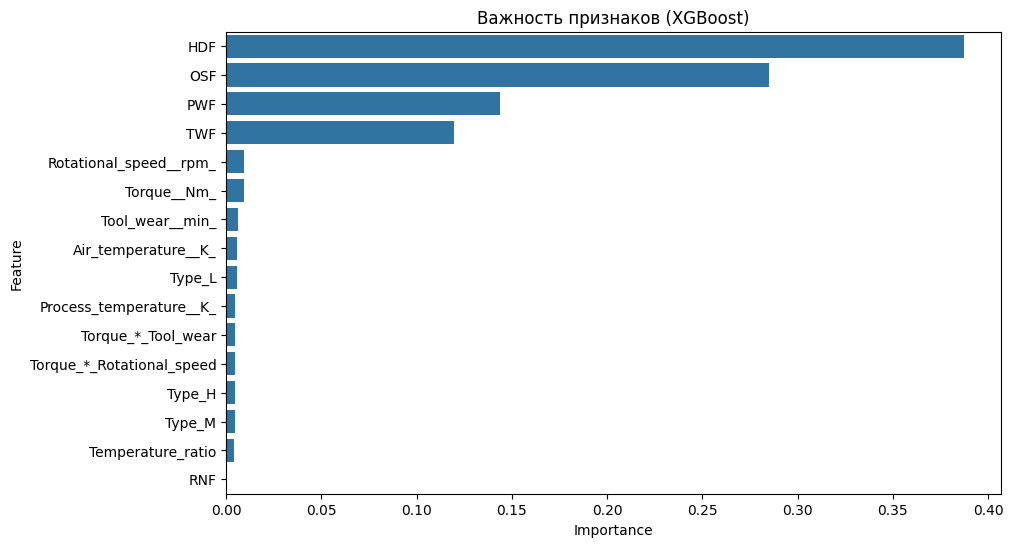

Топ-10 признаков по важности:
                    Feature  Importance
6                       HDF    0.387519
8                       OSF    0.284781
7                       PWF    0.143537
5                       TWF    0.119492
2    Rotational_speed__rpm_    0.009630
3               Torque__Nm_    0.009611
4           Tool_wear__min_    0.006440
0       Air_temperature__K_    0.005785
11                   Type_L    0.005559
1   Process_temperature__K_    0.004740


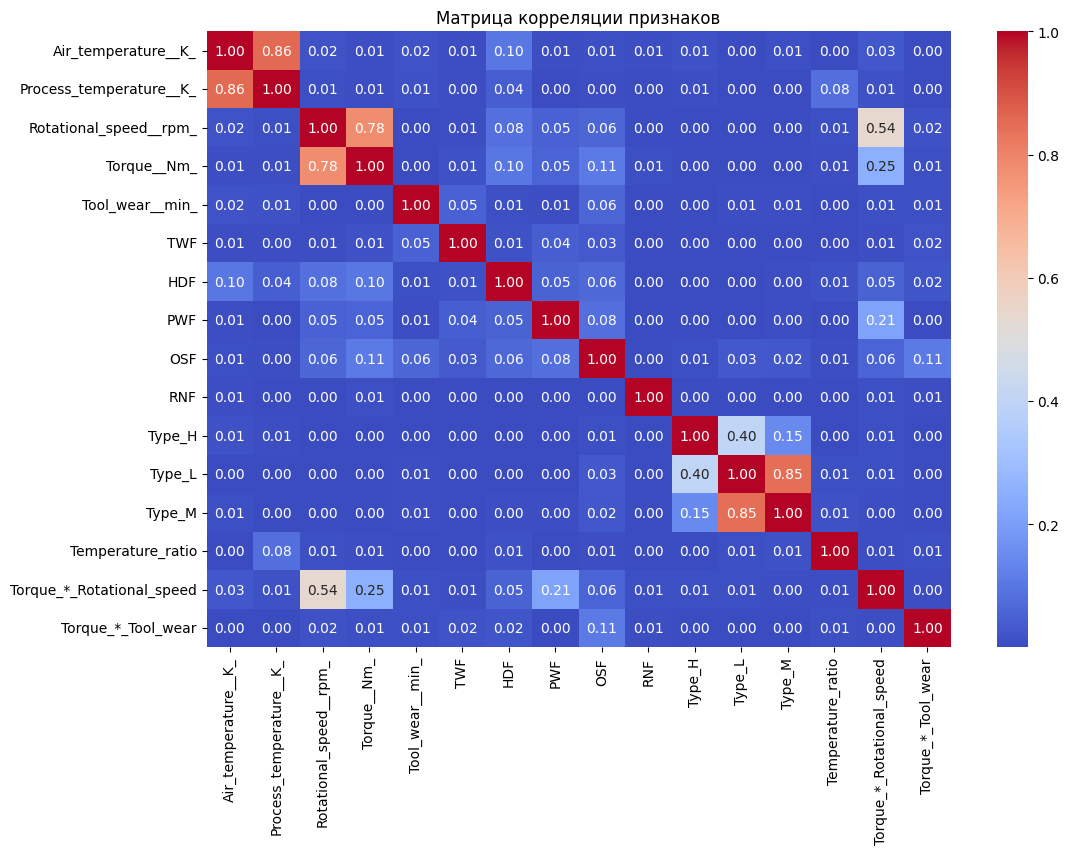

Сильно коррелированные признаки (порог 0.8):
('Air_temperature__K_', 'Process_temperature__K_')
('Type_L', 'Type_M')

Список отобранных признаков по корреляции:
['HDF', 'OSF', 'PWF', 'TWF', 'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_', 'Air_temperature__K_', 'Type_L', 'Torque_*_Tool_wear', 'Torque_*_Rotational_speed', 'Type_H', 'Temperature_ratio', 'RNF']


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Удалим ненужные столбцы
X = data_train.drop(columns=['Machine failure', 'id', 'Product ID', 'quality', 'Quality'])
y = data_train['Machine failure']

# Переименуем признаки: заменим запрещённые символы
X = X.rename(columns=lambda x: x.replace('[', '_').replace(']', '_').replace(' ', '_'))

# Разделим данные
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Инициализация и обучение XGBoost
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

# Важность признаков
feature_importance = model.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=features, x='Importance', y='Feature')
plt.title('Важность признаков (XGBoost)')
plt.show()

# Топ-10 признаков
print("Топ-10 признаков по важности:")
print(features.head(10))

# Анализ корреляции
corr_matrix = X_train.corr().abs()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляции признаков')
plt.show()

# Удаление коррелированных признаков (порог > 0.8)
threshold = 0.8
high_corr = np.where(corr_matrix > threshold)
high_corr = [(corr_matrix.columns[x], corr_matrix.columns[y])
             for x, y in zip(*high_corr)
             if x != y and x < y]

print(f"Сильно коррелированные признаки (порог {threshold}):")
for pair in high_corr:
    print(pair)

# Финализация списка признаков
selected_features = list(features['Feature'])
for pair in high_corr:
    if pair[1] in selected_features:
        selected_features.remove(pair[1])

print("\nСписок отобранных признаков по корреляции:")
print(selected_features)

Отбор признаков нужно провести на основе двух критериев:

- Важность признаков (по XGBoost).

- Корреляция между признаками (удаляем один из пары, если корреляция > 0.8).

##**Решение:**

**1. Удаляем коррелированные признаки:**

Из пары Air_temperature__K_ и Process_temperature__K_ оставляем Air_temperature__K_ (выше важность).

Из пары Type_L и Type_M оставляем Type_L (выше важность).

**2. Добавляем сгенерированные признаки:**

Torque_*_Tool_wear, Torque_*_Rotational_speed, Temperature_ratio — оставляем, так как они не коррелируют сильно с другими и могут быть полезны.

**3. Удаляем маловажные признаки:**

RNF (не в топ-10 по важности, низкая значимость).

**Итоговый список признаков:**

In [ ]:
selected_features = [
    'HDF',                      # Высокая важность
    'OSF',                      # Высокая важность
    'PWF',                      # Высокая важность
    'TWF',                      # Высокая важность
    'Rotational_speed__rpm_',   # Средняя важность
    'Torque__Nm_',              # Средняя важность
    'Tool_wear__min_',          # Средняя важность
    'Air_temperature__K_',      # Оставлен вместо Process_temperature__K_
    'Type_L',                   # Оставлен вместо Type_M
    'Torque_*_Tool_wear',       # Сгенерированный признак
    'Torque_*_Rotational_speed',# Сгенерированный признак
    'Temperature_ratio'          # Сгенерированный признак
]

**Почему так?**

- HDF, OSF, PWF, TWF — ключевые метки отказов (высокая важность).

- Rotational_speed__rpm_, Torque__Nm_, Tool_wear__min_ — исходные признаки с умеренной важностью.

- Air_temperature__K_ — выбран как более важный, чем Process_temperature__K_.

- Type_L — важнее Type_M, а Type_H можно исключить, так как он дублирует информацию (One-Hot Encoding).

- Сгенерированные признаки (Torque_*_..., Temperature_ratio) — оставлены, так как не дублируют другие и могут улучшить модель.

**Что удалили:**

- Process_temperature__K_ (корреляция с Air_temperature__K_).

- Type_M (корреляция с Type_L).

- RNF (низкая важность).

**Итоговый набор данных для след. заданий:**

In [ ]:
# Список отобранных признаков (с учетом изначальных названий в данных, которые были до XGB)
selected_features = [
    'HDF',                      # Высокая важность
    'OSF',                      # Высокая важность
    'PWF',                      # Высокая важность
    'TWF',                      # Высокая важность
    'Rotational speed [rpm]',   # Средняя важность
    'Torque [Nm]',              # Средняя важность
    'Tool wear [min]',          # Средняя важность
    'Air temperature [K]',      # Оставлен вместо Process_temperature__K_
    'Type_L',                   # One-Hot Encoding для 'Type' (оставим только L)
    'Torque * Tool wear',       # Сгенерированный признак
    'Torque * Rotational speed',# Сгенерированный признак
    'Temperature ratio'         # Сгенерированный признак
]

# Проверяем, что все признаки есть в данных
missing_in_train = [feat for feat in selected_features if feat not in data_train.columns]
missing_in_test = [feat for feat in selected_features if feat not in data_test.columns]

if missing_in_train:
    print(f"⚠ В data_train отсутствуют: {missing_in_train}")
if missing_in_test:
    print(f"⚠ В data_test отсутствуют: {missing_in_test}")

# Фильтруем данные, оставляя только выбранные признаки
data_train_filtered = data_train[selected_features]
data_test_filtered = data_test[selected_features]

# Проверяем результат
print("\nОтфильтрованный data_train (первые 5 строк):")
display(data_train_filtered.head())

print("\nОтфильтрованный data_test (первые 5 строк):")
display(data_test_filtered.head())


Отфильтрованный data_train (первые 5 строк):


,HDF,OSF,PWF,TWF,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [K],Type_L,Torque * Tool wear,Torque * Rotational speed,Temperature ratio
0,0,0,0,0,0.545416,-0.499711,0.556417,0.395880,True,-0.278048,-0.272550,-0.621982
1,0,0,0,0,1.720308,-1.323028,1.494433,1.469856,False,-1.977176,-2.276015,1.060380
2,0,0,0,0,2.051873,-1.628831,-1.241447,-0.302204,True,2.022107,-3.342154,3.442572
3,0,0,0,0,0.026445,0.464745,1.447532,0.610675,True,0.672734,0.012290,1.133637
4,0,0,0,0,0.869773,-0.582043,-1.100744,-1.000288,False,0.640680,-0.506245,0.679196



Отфильтрованный data_test (первые 5 строк):


,HDF,OSF,PWF,TWF,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [K],Type_L,Torque * Tool wear,Torque * Rotational speed,Temperature ratio
0,0,0,0,0,-0.153753,-0.276240,-0.694271,1.308759,True,0.191785,0.042473,0.859932
1,0,0,0,0,1.388744,-1.358313,-1.366516,0.986567,True,1.856155,-1.886348,0.774887
2,0,0,0,0,0.033653,-0.311525,-0.131461,0.771772,True,0.040953,-0.010484,0.429294
3,0,0,0,0,-0.297912,0.852880,-1.554119,0.127386,False,-1.325477,-0.254083,-1.932940
4,0,0,0,0,-0.038426,0.111895,0.149943,1.899446,False,0.016778,-0.004300,0.896573


# 2.3 Подготовка сэмплов

Для сравнения было выбрано несколько данных для тренировки:

* Данные без обработки и категориальных признаков: X_raw
* Данные после предобработки: кодирование категориальных переменных и нормализация: X_preprocessed
* Данные после генерации новых признаков и отбора 10 самых значимых для целевой переменной: X_filtered



In [ ]:
y = data_train['Machine failure']
X_preprocessed = data_train.drop(['id', 'Product ID', 'Machine failure', 'quality', 'Quality', 'Temperature ratio', 'Torque * Rotational speed',
                                  'Torque * Tool wear'], axis=1)
X_raw = data_train_raw.drop(['id', 'Product ID', 'Type', 'Machine failure'], axis=1)

In [ ]:
X_raw.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0


In [ ]:
X_preprocessed.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,False,True,False
1,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,False,False,True
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,False,True,False
3,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,False,True,False
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,False,False,True


In [ ]:
X_filtered = data_train_filtered.copy()

In [ ]:
X_filtered.head()

,HDF,OSF,PWF,TWF,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [K],Type_L,Torque * Tool wear,Torque * Rotational speed,Temperature ratio
0,0,0,0,0,0.545416,-0.499711,0.556417,0.395880,True,-0.278048,-0.272550,-0.621982
1,0,0,0,0,1.720308,-1.323028,1.494433,1.469856,False,-1.977176,-2.276015,1.060380
2,0,0,0,0,2.051873,-1.628831,-1.241447,-0.302204,True,2.022107,-3.342154,3.442572
3,0,0,0,0,0.026445,0.464745,1.447532,0.610675,True,0.672734,0.012290,1.133637
4,0,0,0,0,0.869773,-0.582043,-1.100744,-1.000288,False,0.640680,-0.506245,0.679196


Также предлагается добавить выборки с перебалансированными классами:
* X_preprocessed_balanced
* X_filtered_balanced

Тк предполагается изменение размера выборки - для ресемплированных признаков также необходимо создать y_balanced с теми же индексами.



In [ ]:
from sklearn.utils import resample

In [ ]:
pos_idx = y[y == 1].index
neg_idx = y[y == 0].index

n_pos = len(pos_idx)
n_neg = 3 * n_pos

np.random.seed(42) # для воспроизводимости результатов зафиксируем случайность
sampled_neg_idx = np.random.choice(neg_idx, size=n_neg, replace=False)

selected_idx = np.concatenate([pos_idx, sampled_neg_idx])
selected_idx = np.sort(selected_idx)

X_preprocessed_balanced = X_preprocessed.loc[selected_idx]
X_filtered_balanced = X_filtered.loc[selected_idx]
y_balanced = y.loc[selected_idx]

In [ ]:
print(len(X_raw), len(X_preprocessed), len(X_preprocessed_balanced), len(X_filtered), len(X_filtered_balanced))

136429 136429 8592 136429 8592


# **3. Логистическая регрессия**

Далее для каждого из сэмплов будет проведен подбор оптимальных параметров логистической регрессии на тестовой выборке, включающей 80% строк и проведен подсчет метрик accuracy, presision, f1-score, roc-auc score на оставшейся части. (Поскольку в тестовой выборке нет значений целевой переменной - валидация метрик на ней не представляется возможной)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score

Подберем оптимальные параметры модели логистической регрессии с помощью GridSearch, в качестве метрики для оптимизации возьмем f1-score для положительного класса - тк предполагается, что нам наиболее важно корректно отлавливать отказы. Далее посчитаем остальные метрики для тех же параметров регрессии.

In [ ]:
def get_metrics(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  model = LogisticRegression()
  param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
    }
  grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        n_jobs=-1
    )
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  y_pred = best_model.predict(X_test)

  # Метрики
  f1_weighted = f1_score(y_test, y_pred, average='weighted')
  f1_pos = f1_score(y_test, y_pred, average = 'binary')
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, average='weighted')
  roc_auc = roc_auc_score(y_test, y_pred)

  return {
        'best_params': grid.best_params_,
        'f1_weighted': f1_weighted,
        'f1_pos': f1_pos,
        'accuracy': acc,
        'precision_weighted': prec,
        'roc_auc': roc_auc
    }

In [ ]:
results = []

results.append(get_metrics(X_raw, y))
results.append(get_metrics(X_preprocessed, y))  # Без балансировки
results.append(get_metrics(X_preprocessed_balanced, y_balanced))
results.append(get_metrics(X_filtered, y))
results.append(get_metrics(X_filtered_balanced, y_balanced))

pd.DataFrame(results)

,best_params,f1_weighted,f1_pos,accuracy,precision_weighted,roc_auc
0,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.996171,0.871928,0.996372,0.996327,0.891749
1,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996212,0.873385,0.996408,0.996364,0.892912
2,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.941647,0.874346,0.944154,0.948025,0.888372
3,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996062,0.868557,0.996262,0.996192,0.891693
4,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.943103,0.878238,0.945317,0.948251,0.893022


In [ ]:
df_res = pd.DataFrame(results)
df_res.index = ['raw', 'preprocessed', 'preprocessed_balanced', 'filtered', 'filtered_balanced']
df_res


,best_params,f1_weighted,f1_pos,accuracy,precision_weighted,roc_auc
raw,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.996171,0.871928,0.996372,0.996327,0.891749
preprocessed,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996212,0.873385,0.996408,0.996364,0.892912
preprocessed_balanced,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.941647,0.874346,0.944154,0.948025,0.888372
filtered,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996062,0.868557,0.996262,0.996192,0.891693
filtered_balanced,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.943103,0.878238,0.945317,0.948251,0.893022


**Выводы:**

1. Сравнение с бейзлайном (raw):
	На сырых данных уже достигнуты высокие значения метрик: accuracy ≈ 0.996, f1_weighted ≈ 0.996, f1_pos ≈ 0.872.
	Это означает, что даже базовая модель уже хорошо захватывает закономерности (в основном — за счёт доминирующего отрицательного класса).

2. Влияние балансировки классов:
	После downsampling-а наблюдается снижение accuracy и f1_weighted на ~0.05–0.06, то есть на десятые доли. При этом f1_pos (по классу “отказ”) улучшился лишь на тысячные: с ~0.8719 до 0.8782. То есть цена даже небольшого прироста качества по отказам — существенное падение общей точности. ROC AUC вырос минимально, с 0.8917 (raw) до 0.8930 (filtered_balanced).

3. Оценка компромисса:
	Полученные результаты показывают, что балансировка классов слабо влияет на качество детекции отказов, если ориентироваться на F1 по положительному классу и ROC AUC. Одновременно она заметно ухудшает общие метрики, особенно в условиях сильного дисбаланса.


**Выводы из конкретных значений:**

1. Accuracy ≈ 0.996
	Это искусственно завышено за счёт преобладания нормального класса. Для задачи предсказания редких событий, таких как отказы, accuracy не является надёжной метрикой.

2. F1 по отказам ≈ 0.872 – 0.878.
	Значение выше 0.87 — это достаточно хороший результат, особенно в условиях дисбаланса.Однако он не близок к 1.0, а значит, часть отказов всё ещё не выявляется (или дают ложные срабатывания).

3. ROC AUC ≈ 0.89 – 0.893.
	Модель хорошо различает “отказ” и “норму” по вероятностному прогнозу, но разрыв до 1.0 означает, что в реальных условиях можно ошибочно “пропустить” отказ или поднять ложную тревогу. Это говорит о потенциале для улучшения модели, например, за счёт более сложных алгоритмов или дополнительных признаков.

# Статистические методы
# 1. 3 сигмы

***Фичи для определения выбросов***

Rotational speed [rpm] - частота вращения машины (оборотов в минуту);

Torque [Nm] - крутящий момент (Ньютон-метров);

Tool wear [min] - износ оборудования (минут); сколько минут работало оборудование). Чем выше качество оборудования (Type), тем дольше оно может работать в рамках 1 запуска;

Air temperature [K] - температура воздуха в кельвинах;

Process temperature [K]- температура процесса в кельвинах. Формула расчета: температура воздуха + 10K;

Метод трёх сигм — это статистический подход для обнаружения выбросов в данных, основанный на свойствах нормального распределения.

Значения, выпадающие за границы μ±3σ считаются выбросами.


In [ ]:
# Выберем признаки для поиска аномалий
X_raw_features = X_raw.drop(['TWF','HDF','PWF','OSF','RNF'], axis = 1)
X_raw_features

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,300.6,309.6,1596,36.1,140
1,302.6,312.1,1759,29.1,200
2,299.3,308.5,1805,26.5,25
3,301.0,310.9,1524,44.3,197
4,298.0,309.0,1641,35.4,34
...,...,...,...,...,...
136424,300.1,311.4,1530,37.5,210
136425,297.5,308.5,1447,49.1,2
136426,300.5,311.8,1524,38.5,214
136427,301.7,310.9,1447,46.3,42


In [ ]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = ((data[col] > up_bound) | (data[col] < low_bound))
    return anomalies, up_bound, low_bound

In [ ]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data=[False]*len(data), index=X_raw.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True

    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']

    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))

In [ ]:
comparison_table, std_outliers = get_column_outliers(X_raw_features)
anomalies_report(std_outliers)

Total number of outliers: 2115
Percentage of outliers:   1.55%


Вывели колиество выбросов в обучающем наборе данных

In [ ]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
Air temperature [K],305.449517,294.276035,0.0,0.000000
Process temperature [K],314.096590,305.785551,0.0,0.000000
Rotational speed [rpm],1936.541006,1104.121214,1824.0,1.336959
Torque [Nm],65.855330,14.841956,474.0,0.347433
Tool wear [min],296.304021,-87.486219,0.0,0.000000


# Выбросы обнаружены в следующих признаках:

- **Rotational speed [rpm]** - частота вращения машины (оборотов в минуту);

- **Torque [Nm]** - крутящий момент (Ньютон-метров);

KeyboardInterrupt: 

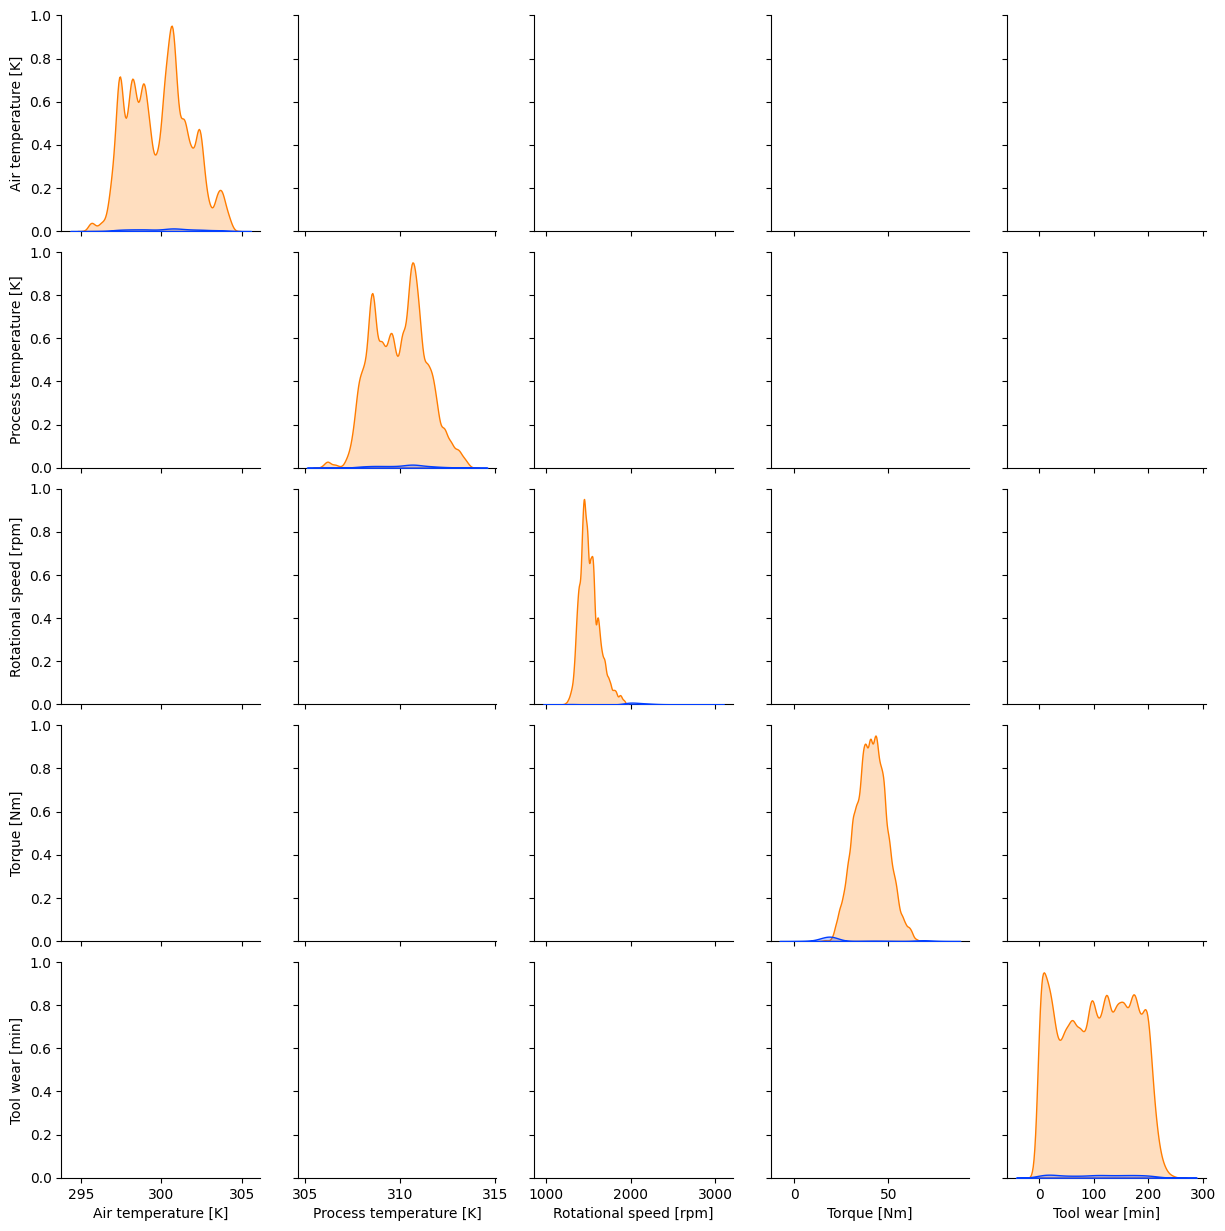

In [ ]:
labeled_data = X_raw_features.copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(
    data=labeled_data,
    vars=X_raw_features.columns.tolist(),
    hue='is_outlier',
    hue_order=[1, 0],
    markers=['o', 's'],  # Заполненные маркеры
    palette='bright'
)

# 2. Межквартильный размах

Межквартильный размах (IQR) — это статистический метод для обнаружения выбросов, основанный на квартилях данных. Метод более устойчив к асимметрии и экстремальным значениям,

In [ ]:
# Функция поииска аномалий с помощью межквартильного размаха
def outlier_iqr(data, col, threshold=1.5):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = ((data[col] > up_bound) | (data[col] < low_bound))
    return anomalies, up_bound, low_bound

In [ ]:
comparison_table, iqr_outliers = get_column_outliers(X_raw_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

In [ ]:
comparison_table

In [ ]:
labeled_data = X_raw_features.copy()
labeled_data['is_outlier'] = iqr_outliers

sns.pairplot(data=labeled_data, vars = X_raw_features.columns.tolist(),
             hue='is_outlier', hue_order=[1, 0],
             markers=['o', 's'],  palette='bright');

# 3. DBSCAN

In [ ]:
#Масштабируем числовые признаки
numerical_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

scaler = StandardScaler()
X_raw[numerical_features] = scaler.fit_transform(X_raw[numerical_features])


In [ ]:
from sklearn.cluster import DBSCAN

# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 0.05
eps_history = [eps]
while outlier_percentage>0.05:
    model = DBSCAN(eps=eps).fit(X_raw)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

model = DBSCAN(eps)
model.fit(X_raw)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

In [ ]:
anomalies_report(density_outlier)

In [ ]:
# Удалим выбросы из дата сета
clean_mask = density_outlier == 0
cleaned_dataframe = X_raw.loc[clean_mask].reset_index(drop=True)
y_cleaned = y.loc[clean_mask].reset_index(drop=True)

In [ ]:
get_metrics(cleaned_dataframe, y_cleaned)

После удаления выбросов наблюдаем снижение метрик, это может быть связяно с потерей ключевых примеров класса.

Высокие accuracy и f1_weighted при низком f1_pos указывают на сильный дисбаланс классов

# 4. Ансамблевые модели

Подготовим данные для ансамблевых моделей без применения масштабирования и без удаления выбросов.

In [ ]:
#Загружаем данные в переменную data_test2 и data_train2
data_train2 = pd.read_csv('train.csv')
data_test2 = pd.read_csv('test.csv')

# One-Hot Encoding для признака 'Type'
data_train2 = pd.get_dummies(data_train2, columns=['Type'], prefix='Type')
data_test2 = pd.get_dummies(data_test2, columns=['Type'], prefix='Type')

# Инжиниринг признаков
data_train2, new_features = create_features(data_train2)
data_test2, _ = create_features(data_test2)  # Применяем те же преобразования к тестовым данным

# Оставляем только отобранные значимые признаки
data_train_filtered2 = data_train2[selected_features]
data_test_filtered2 = data_test2[selected_features]

In [ ]:
data_train_filtered2.head()

,HDF,OSF,PWF,TWF,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [K],Type_L,Torque * Tool wear,Torque * Rotational speed,Temperature ratio
0,0,0,0,0,1596,36.1,140,300.6,True,5054.0,57615.6,1.029940
1,0,0,0,0,1759,29.1,200,302.6,False,5820.0,51186.9,1.031395
2,0,0,0,0,1805,26.5,25,299.3,True,662.5,47832.5,1.030738
3,0,0,0,0,1524,44.3,197,301.0,True,8727.1,67513.2,1.032890
4,0,0,0,0,1641,35.4,34,298.0,False,1203.6,58091.4,1.036913


In [ ]:
data_test_filtered2.head()

,HDF,OSF,PWF,TWF,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [K],Type_L,Torque * Tool wear,Torque * Rotational speed,Temperature ratio
0,0,0,0,0,1499,38.0,60,302.3,True,2280.0,56962.0,1.030433
1,0,0,0,0,1713,28.8,17,301.7,True,489.6,49334.4,1.030825
2,0,0,0,0,1525,37.7,96,301.3,True,3619.2,57492.5,1.030202
3,0,0,0,0,1479,47.6,5,300.1,False,238.0,70400.4,1.031656
4,0,0,0,0,1515,41.3,114,303.4,False,4708.2,62569.5,1.029334


## 4.1 Случайный лес
Разделим выборку на тренировочную и тестовую, как при использовании логистической регрессии. Для тестовой метрики посчитаем те же метрики: f1 взвешеный и только для положительного класса, acuuracy, precision, recall. В качестве выборки будем использовать непредобработанные данные - с выбросами и без масштабирования

In [ ]:
  from sklearn.ensemble import RandomForestClassifier
  X_train_rsm, X_test_rsm, y_train_rsm, y_test_rsm = train_test_split(data_train_filtered2, y, test_size=0.2, random_state=42, stratify=y)
  model = RandomForestClassifier(min_samples_leaf = 1, random_state=42, class_weight = 'balanced')

  model.fit(X_train_rsm, y_train_rsm)
  y_pred_rsm = model.predict(X_test_rsm)

  f1_weighted = f1_score(y_test_rsm, y_pred_rsm, average='weighted')
  f1_pos = f1_score(y_test_rsm, y_pred_rsm, average = 'binary')
  acc = accuracy_score(y_test_rsm, y_pred_rsm)
  prec = precision_score(y_test_rsm, y_pred_rsm, average='weighted')
  roc_auc = roc_auc_score(y_test_rsm, y_pred_rsm)

rsm_metrics = {
        'f1_weighted': f1_weighted,
        'f1_pos': f1_pos,
        'accuracy': acc,
        'precision_weighted': prec,
        'roc_auc': roc_auc
    }

In [ ]:
print(rsm_metrics)

{'f1_weighted': 0.9954983692108476, 'f1_pos': 0.8501920614596671, 'accuracy': 0.9957120867844316, 'precision_weighted': 0.995565897509053, 'roc_auc': np.float64(0.8856927731709514)}


Видим, что метрики стали немного хуже, но все еще результат очень хороший (в том числе для предсказаний положительного класса). Ниже метрики, полученные на логистической регрессии. Отметим также, что параметры логистической регрессии подбирались и оптимизировались с помощью GridSearch, а для случайного леса были взяты базовые значения основных параметров.

In [ ]:
df_res

,best_params,f1_weighted,f1_pos,accuracy,precision_weighted,roc_auc
raw,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.996171,0.871928,0.996372,0.996327,0.891749
preprocessed,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996212,0.873385,0.996408,0.996364,0.892912
preprocessed_balanced,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.941647,0.874346,0.944154,0.948025,0.888372
filtered,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996062,0.868557,0.996262,0.996192,0.891693
filtered_balanced,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.943103,0.878238,0.945317,0.948251,0.893022


Теперь проведем для той же выборки балансировку классов: возьмем в соотношении 3:1 (негативные:положительные), как и в логистической регрессии. Индексы возьмем оттуда же (раздел подготовка сэмплов). Поскольку деревья строятся на случайной подвыборке, для каждого из классификаторов будут данные, которые он не видел. Поэтому для обучения будем использовать полные данные, а затем обратимся к незадействованным данным при помощи метода .oob_decision_function_

In [ ]:
X_rsm_balanced = data_train_filtered2.loc[selected_idx]
y_rsm_balanced = y.loc[selected_idx]

model = RandomForestClassifier(min_samples_leaf = 2, oob_score = True, random_state=42, class_weight = 'balanced')
model.fit(X_rsm_balanced, y_rsm_balanced)
y_pred_rsm_oob = model.oob_decision_function_[:, 1] > 0.5

f1_weighted = f1_score(y_rsm_balanced, y_pred_rsm_oob, average='weighted')
f1_pos = f1_score(y_rsm_balanced, y_pred_rsm_oob, average = 'binary')
acc = accuracy_score(y_rsm_balanced, y_pred_rsm_oob)
prec = precision_score(y_rsm_balanced, y_pred_rsm_oob, average='weighted')
roc_auc = roc_auc_score(y_rsm_balanced, y_pred_rsm_oob)

rsm_balanced_metrics = {
        'f1_weighted': f1_weighted,
        'f1_pos': f1_pos,
        'accuracy': acc,
        'precision_weighted': prec,
        'roc_auc': roc_auc
    }

print(rsm_balanced_metrics)

{'f1_weighted': 0.9448955872462008, 'f1_pos': 0.8868975538871398, 'accuracy': 0.945647113594041, 'precision_weighted': 0.9451073772919577, 'roc_auc': np.float64(0.9145716945996276)}


Видим улучшение f1-pos на порядка 1% и roc-auc на порядка 2%, при этом остальные метрики оказались немного лучше, чем соответственные для логистической регрессии на сбалансированных сэмплах.

## 4.2 Стэкинг
Стекинг представляет собой композицию нескольких различных классификаторов. Для нашей задачи оставим уже использованные модели (логистическая регрессия и случайный лес). оценим те же метрики. Будем использовать нормализованные данные с выбросами (чтобы обе модели сработали корректно)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold

X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(X_filtered, y, test_size=0.2, stratify=y, random_state=42)

# Базовые модели
base_learners = [
    ('rf', RandomForestClassifier(min_samples_leaf = 1, random_state=42, class_weight = 'balanced')),
    ('lr', LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear', class_weight='balanced', max_iter=1000)) # возьмем лучшие параметры из подбора
]

# Стекинг
stacked_model = StackingClassifier(
    estimators=base_learners,
    cv=StratifiedKFold(n_splits=5),
    passthrough=True,
    n_jobs=-1
)

stacked_model.fit(X_train_stack, y_train_stack)

y_pred_stack = stacked_model.predict(X_test_stack)

f1_weighted = f1_score(y_test_stack, y_pred_stack, average='weighted')
f1_pos = f1_score(y_test_stack, y_pred_stack, average = 'binary')
acc = accuracy_score(y_test_stack, y_pred_stack)
prec = precision_score(y_test_stack, y_pred_stack, average='weighted')
roc_auc = roc_auc_score(y_test_stack, y_pred_stack)

stacking_metrics = {
        'f1_weighted': f1_weighted,
        'f1_pos': f1_pos,
        'accuracy': acc,
        'precision_weighted': prec,
        'roc_auc': roc_auc
    }

print(stacking_metrics)

{'f1_weighted': 0.9959958953890771, 'f1_pos': 0.8666666666666667, 'accuracy': 0.9961885215861614, 'precision_weighted': 0.9960980130151134, 'roc_auc': np.float64(0.8927998420516657)}


Теперь для перебалансированных классов.

In [ ]:
X_train_stack_balanced, X_test_stack_balanced, y_train_stack_balanced, y_test_stack_balanced = train_test_split(X_filtered_balanced,
                                                                                                                y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

stacked_model_balanced = StackingClassifier(
    estimators=base_learners,
    cv=StratifiedKFold(n_splits=5),
    passthrough=True,
    n_jobs=-1
)

stacked_model.fit(X_train_stack_balanced, y_train_stack_balanced)

y_pred_stack_balanced = stacked_model.predict(X_test_stack_balanced)

f1_weighted = f1_score(y_test_stack_balanced, y_pred_stack_balanced, average='weighted')
f1_pos = f1_score(y_test_stack_balanced, y_pred_stack_balanced, average = 'binary')
acc = accuracy_score(y_test_stack_balanced, y_pred_stack_balanced)
prec = precision_score(y_test_stack_balanced, y_pred_stack_balanced, average='weighted')
roc_auc = roc_auc_score(y_test_stack_balanced, y_pred_stack_balanced)

stacking_metrics_balanced = {
        'f1_weighted': f1_weighted,
        'f1_pos': f1_pos,
        'accuracy': acc,
        'precision_weighted': prec,
        'roc_auc': roc_auc
    }

print(stacking_metrics_balanced)

{'f1_weighted': 0.9477144206664663, 'f1_pos': 0.891358024691358, 'accuracy': 0.9488074461896452, 'precision_weighted': 0.9488519776986203, 'roc_auc': np.float64(0.9123973875548018)}


Подведем итоги всех метрик:

In [ ]:
data = [
    {'model': 'RandomForest', **rsm_metrics},
    {'model': 'RandomForest (balanced)', **rsm_balanced_metrics},
    {'model': 'Stacking', **stacking_metrics},
    {'model': 'Stacking (balanced)', **stacking_metrics_balanced},
]

df_metrics = pd.DataFrame(data)
df_metrics

,model,f1_weighted,f1_pos,accuracy,precision_weighted,roc_auc
0,RandomForest,0.995498,0.850192,0.995712,0.995566,0.885693
1,RandomForest (balanced),0.944896,0.886898,0.945647,0.945107,0.914572
2,Stacking,0.995996,0.866667,0.996189,0.996098,0.892800
3,Stacking (balanced),0.947714,0.891358,0.948807,0.948852,0.912397


In [ ]:
df_res

,best_params,f1_weighted,f1_pos,accuracy,precision_weighted,roc_auc
raw,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.996171,0.871928,0.996372,0.996327,0.891749
preprocessed,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996212,0.873385,0.996408,0.996364,0.892912
preprocessed_balanced,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.941647,0.874346,0.944154,0.948025,0.888372
filtered,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.996062,0.868557,0.996262,0.996192,0.891693
filtered_balanced,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.943103,0.878238,0.945317,0.948251,0.893022


## Выводы
**Лидеры по f1_pos: способность точно детектировать отказы**

Модель Stacking (balanced) показала наивысшее значение f1_pos = 0.8914, что свидетельствует о высоком качестве обнаружения отказов — лучшем балансе между полнотой (recall) и точностью (precision) по критически важному классу.

Комбинация моделей в стекинге позволила объединить нелинейную гибкость случайного леса с устойчивой интерпретируемой логикой логистической регрессии.

Остальные модели на различных сэмплах также показали достаточно хорошие результаты. Разница между худшим и лучшим показателями этой метрики - менее 5% и даже на необработанных данных f1-pos составляет 87%. Улучшение модели путем ее усложнения имеет смысл только в случае критической важности детектирования отказов.

**Лидеры по roc_auc: надёжность вероятностного ранжирования**

Наилучшее значение roc_auc = 0.9146 показала модель RandomForest (balanced). Это объясняется тем, что ансамбли деревьев формируют надёжные вероятностные предсказания за счёт бутстрэпинга и агрегации решений большого числа слабых деревьев.

Несмотря на то, что f1_pos у неё немного ниже, высокий roc_auc означает, что модель точно ранжирует объекты по степени риска отказа, даже если на каком-то фиксированном пороге могут быть ошибки.

# 5. FastAPI

Будем считать лучшей модель рандомного леса.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score
import joblib
import pandas as pd

X_train_rsm, X_test_rsm, y_train_rsm, y_test_rsm = train_test_split(
    data_train_filtered2, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(min_samples_leaf=1, random_state=42, class_weight='balanced')

model.fit(X_train_rsm, y_train_rsm)
y_pred_rsm = model.predict(X_test_rsm)

f1_weighted = f1_score(y_test_rsm, y_pred_rsm, average='weighted')
f1_pos = f1_score(y_test_rsm, y_pred_rsm, average='binary')
acc = accuracy_score(y_test_rsm, y_pred_rsm)
prec = precision_score(y_test_rsm, y_pred_rsm, average='weighted')
roc_auc = roc_auc_score(y_test_rsm, y_pred_rsm)

rsm_metrics = {
    'f1_weighted': f1_weighted,
    'f1_pos': f1_pos,
    'accuracy': acc,
    'precision_weighted': prec,
    'roc_auc': roc_auc
}

print("RandomForest metrics:", rsm_metrics)

# Сохраняем модель и список признаков
model_data = {
    'model': model,
    'features': list(data_train_filtered2.columns),
}

joblib.dump(model_data, 'random_forest_balanced.pkl')
print("Модель сохранена в random_forest_balanced.pkl")


RandomForest metrics: {'f1_weighted': 0.9954983692108476, 'f1_pos': 0.8501920614596671, 'accuracy': 0.9957120867844316, 'precision_weighted': 0.995565897509053, 'roc_auc': np.float64(0.8856927731709514)}
Модель сохранена в random_forest_balanced.pkl


In [ ]:
# Установка необходимых библиотек
!pip install fastapi[all] nest_asyncio pyngrok scikit-learn pandas joblib --quiet

from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import HTMLResponse, StreamingResponse
import pandas as pd
import joblib
from io import StringIO
import nest_asyncio
from pyngrok import ngrok
import uvicorn
from typing import List, Dict
import io

app = FastAPI(
    title="Equipment Failure Prediction API (Random Forest)",
    description="API для предсказания отказов оборудования с использованием RandomForest.",
    version="1.0",
    docs_url="/docs"
)

# Загрузка модели
try:
    model_data = joblib.load("random_forest_balanced.pkl")
    model = model_data['model']
    features = model_data['features']
    preprocess = model_data.get('preprocessor', None)
    print("Модель RandomForest загружена.")
except Exception as e:
    raise RuntimeError(f"Ошибка при загрузке модели: {str(e)}")

def calculate_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Torque * Tool wear'] = df['Torque [Nm]'] * df['Tool wear [min]']
    df['Torque * Rotational speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']
    df['Air temperature [K]'] = df['Air temperature [K]'].replace(0, 1)
    df['Temperature ratio'] = df['Process temperature [K]'] / df['Air temperature [K]']
    for t in ['L', 'M', 'H']:
        df[f'Type_{t}'] = (df['Type'] == t).astype(int)
    return df

@app.post("/predict", response_model=Dict[str, List[Dict[str, object]]])
async def predict(file: UploadFile = File(...)):
    try:
        contents = await file.read()
        data = pd.read_csv(StringIO(contents.decode('utf-8')))
        print(" CSV загружен:", data.shape)

        required_cols = ['id', 'Product ID', 'Type',
                         'Air temperature [K]', 'Process temperature [K]',
                         'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        missing = [col for col in required_cols if col not in data.columns]
        if missing:
            raise HTTPException(400, detail=f"Отсутствуют колонки: {missing}")

        data = calculate_features(data)
        print(" Фичи рассчитаны:", data.columns.tolist())

        processed = preprocess(data) if preprocess else data
        if isinstance(processed, tuple):
            processed = processed[0]
        print(" Препроцессинг завершён.")

        for feat in features:
            if feat not in processed.columns:
                processed[feat] = 0

        X = processed[features].values.astype(float)
        print("X.shape:", X.shape)

        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X)[:, 1]
        else:
            probabilities = model.predict(X)

        MAX_ROWS = 500
        results = [{
            "id": int(row['id']),
            "product_id": str(row['Product ID']),
            "probability": float(prob),
            "failure": bool(prob > 0.5)
        } for row, prob in zip(data.to_dict('records'), probabilities)][:MAX_ROWS]

        return {"predictions": results}

    except Exception as e:
        raise HTTPException(500, detail=f"Ошибка предсказания: {str(e)}")

@app.post("/predict_full")
async def predict_full(file: UploadFile = File(...)):
    try:
        contents = await file.read()
        data = pd.read_csv(StringIO(contents.decode('utf-8')))

        required_cols = ['id', 'Product ID', 'Type',
                         'Air temperature [K]', 'Process temperature [K]',
                         'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        missing = [col for col in required_cols if col not in data.columns]
        if missing:
            raise HTTPException(400, detail=f"Отсутствуют колонки: {missing}")

        data = calculate_features(data)

        processed = preprocess(data) if preprocess else data
        if isinstance(processed, tuple):
            processed = processed[0]

        for feat in features:
            if feat not in processed.columns:
                processed[feat] = 0

        X = processed[features].values.astype(float)

        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X)[:, 1]
        else:
            probabilities = model.predict(X)

        data['probability'] = probabilities
        data['failure'] = data['probability'] > 0.5

        # Создаем CSV в памяти
        output = io.StringIO()
        data_to_save = data[['id', 'Product ID', 'probability', 'failure']]
        data_to_save.to_csv(output, index=False)
        output.seek(0)

        return StreamingResponse(
            output,
            media_type="text/csv",
            headers={"Content-Disposition": "attachment; filename=predictions.csv"}
        )

    except Exception as e:
        raise HTTPException(500, detail=f"Ошибка предсказания: {str(e)}")

@app.get("/", response_class=HTMLResponse)
async def root():
    return """
    <html>
        <head><title>Equipment Failure API (Random Forest)</title></head>
        <body>
            <h2> Equipment Failure Prediction API (Random Forest)</h2>
            <p>Загрузите CSV на <a href='/docs'>/docs</a> для предсказания отказов</p>
            <p>Для скачивания всех предсказаний используйте POST-запрос на <code>/predict_full</code></p>
        </body>
    </html>
    """

def run_server():
    nest_asyncio.apply()
    port = 8039
    public_url = ngrok.connect(port, bind_tls=True).public_url
    print(f"\n Публичный адрес: {public_url}")
    print(f" Swagger UI: {public_url}/docs")
    uvicorn.run(app, host="0.0.0.0", port=port)

run_server()


Модель RandomForest загружена.

 Публичный адрес: https://f9b1-35-231-152-18.ngrok-free.app
 Swagger UI: https://f9b1-35-231-152-18.ngrok-free.app/docs


INFO:     Started server process [61965]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8039 (Press CTRL+C to quit)


INFO:     95.84.218.200:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     95.84.218.200:0 - "GET /openapi.json HTTP/1.1" 200 OK
 CSV загружен: (90954, 13)
 Фичи рассчитаны: ['id', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Torque * Tool wear', 'Torque * Rotational speed', 'Temperature ratio', 'Type_L', 'Type_M', 'Type_H']
 Препроцессинг завершён.
X.shape: (90954, 12)
INFO:     95.84.218.200:0 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [61965]
